In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import pickle

In [20]:
# Cargar datos
data = pd.read_csv("/content/sample_data/hormigon.csv")

# Separar características y variable objetivo
X = data.drop('strength', axis=1)
y = data['strength']

In [21]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Normalización (solo con stats del train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar el scaler
pickle.dump(scaler, open('scaler_nn.pkl', 'wb'))

## Red neuronal (con algunas mejoras)

#### ✅ `kernel_regularizer=l2(0.001)`

* **Propósito**: Regularización L2 (también conocida como *weight decay*) penaliza los pesos grandes, lo que ayuda a prevenir overfitting.
* **Valor típico**: `0.001` es un valor comúnmente usado. Puedes ajustarlo si ves que el modelo no aprende bien o sobreajusta.

#### ✅ `BatchNormalization()`

* **Propósito**: Normaliza las activaciones dentro de la red, estabilizando el entrenamiento y permitiendo usar tasas de aprendizaje más altas.
* **Dónde usarlo**: Es habitual colocarlo **después** de la capa `Dense` y **antes** de `Dropout`.
* **Nota**: Suele mejorar la velocidad y estabilidad del entrenamiento.

#### ✅ `Dropout(0.3)`

* **Propósito**: Desactiva aleatoriamente algunas neuronas durante el entrenamiento para forzar redundancia en la red y reducir overfitting.
* **Valor**: `0.3` es razonable, aunque puede ajustarse entre `0.2` y `0.5`.

#### ❌ Comentario sobre `Dropout(0.2)`

* Si comentas esta segunda capa `Dropout`, es totalmente válido — dependerá del nivel de regularización que observes necesario.



In [58]:
# Crear modelo secuencial
from tensorflow.keras.regularizers import l2
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    #Dropout(0.2),
    Dense(1)  # salida de regresión
])

# Compilar modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [60]:
# Early stopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


In [61]:
# Entrenar modelo
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1613.0098 - mae: 36.7682 - val_loss: 1383.4302 - val_mae: 33.7927
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1517.5780 - mae: 36.5620 - val_loss: 1346.9238 - val_mae: 33.5477
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1420.0842 - mae: 35.8449 - val_loss: 1308.1000 - val_mae: 33.2533
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1442.2914 - mae: 36.4294 - val_loss: 1268.5787 - val_mae: 32.8990
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1283.8677 - mae: 34.5569 - val_loss: 1231.3303 - val_mae: 32.5382
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1298.6902 - mae: 34.8973 - val_loss: 1181.9547 - val_mae: 31.9783
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1254.4489 - mae: 34.4105 - val_loss: 1134.1112 - val_mae: 31.3975
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1226.7285 - mae: 33.9441 - val_loss: 1075.5496 - val_mae: 30.

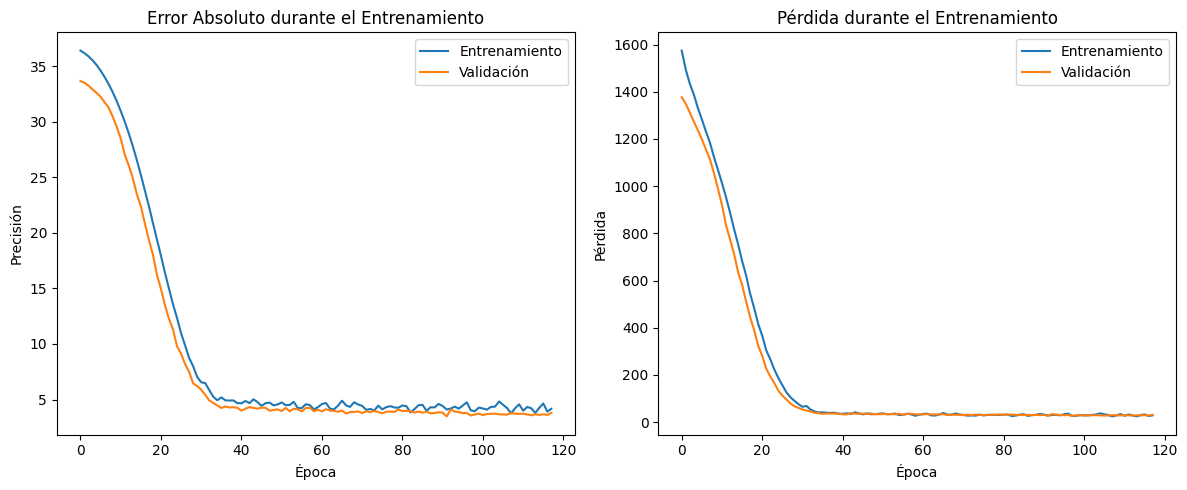

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Gráficas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('Error Absoluto durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.tight_layout()
plt.show()


In [56]:
# Evaluar en test
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print("Test MAE:", test_mae)

# Calcular R²
y_pred = model.predict(X_test_scaled).flatten()
r2 = r2_score(y_test, y_pred)
print("Test R²:", r2)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.3069 - mae: 3.4547 
Test MAE: 3.614229679107666
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test R²: 0.9058508265540042


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


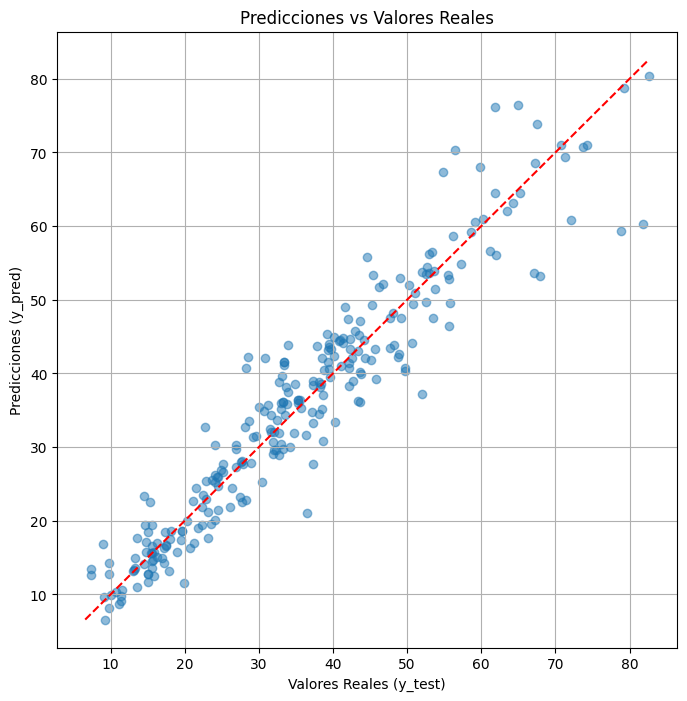

In [57]:
# Predecir en los datos de prueba
y_pred = model.predict(X_test_scaled).flatten()

# Crear la gráfica de dispersión
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales (y_test)')
plt.ylabel('Predicciones (y_pred)')
plt.grid(True)

# Agregar la línea de la bisectriz (y=x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

In [48]:
# Guardar el modelo
model.save("modelo_red_neuronal.keras")

In [49]:
from tensorflow.keras.models import load_model

# Cargar modelo y scaler
modelo_nn = load_model("modelo_red_neuronal.keras")
scaler = pickle.load(open('scaler_nn.pkl', 'rb'))

# Ejemplo: nuevo hormigón
nuevo = {'cement': 141.0, 'slag': 212, 'ash': 0, 'water': 203.5,
         'superplastic': 0, 'coarseagg': 971.8, 'fineagg': 748.5, 'age': 28}
nuevo_df = pd.DataFrame(nuevo, index=[0])
nuevo_scaled = scaler.transform(nuevo_df)

# Predicción
pred = modelo_nn.predict(nuevo_scaled)
print("Predicción:", pred[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predicción: 27.865108
